In [1]:
import os
import glob
import json

import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal

# local .json file with local path info
geladas_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(geladas_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

import mapping_functions as kmap
import koger_general_functions as kgf
from track_validation import get_number_of_validations

In [2]:
annotator_name = 'koger'

observation_name = "DJI_0205_no_GCPs"
pix4d_project_name = "gelada_worked_example_DJI_0205"

# Where all the annotation folders created in 'human-groundtruth-validation.ipynb' are.
root_folder =  os.path.join(local_paths["pix4d_folder"], observation_name,
                            "validation")

validation_files = glob.glob(
    os.path.join(root_folder, f"{annotator_name}_estimated_raster_positions", "*.npy")
)
validation_files.sort()

num_validations = get_number_of_validations(validation_files)
print(f"{num_validations} completed validations for {observation_name}.")

100 completed validations for DJI_0205_no_GCPs.


In [3]:
pix4d_folder = os.path.join(local_paths["pix4d_folder"], observation_name)
pix4d_info = kmap.get_pix4d_info(pix4d_folder, pix4d_project_name, 
                                 pmatrix_sort='simple')

utm_tracks_file = os.path.join(pix4d_folder, 'utm_tracks.npy')
utm_tracks = np.load(utm_tracks_file)

In [4]:
validation_errors = {'errors': [], 'obs_ind': []}
validations_count = 0
for val_file in validation_files:
    track_ind = int(val_file.split('track-')[-1].split('.')[-2])
    obs_ind = int(val_file.split('-')[-3])

    # 2x2 matrix with top row the top left raster location of validation image
    # and bottom row human click location in validation image
    val_raster = np.load(val_file)

    if np.any(val_raster==-1):
        continue

    assert len(val_raster[1:]) == 1, "Need to deal with multiple points in file."

    validations_count += 1
    val_raster = np.sum(val_raster, axis=0)
    val_x_utm, val_y_utm = kmap.raster_to_utm(val_raster[0], val_raster[1], 
                                              pix4d_info)
    x_utm, y_utm = utm_tracks[track_ind, obs_ind]
    
    error = np.linalg.norm([x_utm-val_x_utm, y_utm-val_y_utm])
    
    if error > 5:
        print(track_ind, obs_ind)
    
    calc_raster = True
    if calc_raster:
        val_x_raster = val_raster[0]
        val_y_raster = val_raster[1]
        x_raster, y_raster = kmap.utm_to_raster(x_utm, y_utm, pix4d_info)
        error = np.linalg.norm([x_raster-val_x_raster, y_raster-val_y_raster])
    
    
    validation_errors['errors'].append(error)
    validation_errors['obs_ind'].append(obs_ind)
print(f"{validations_count} validations processed.")

100 validations processed.


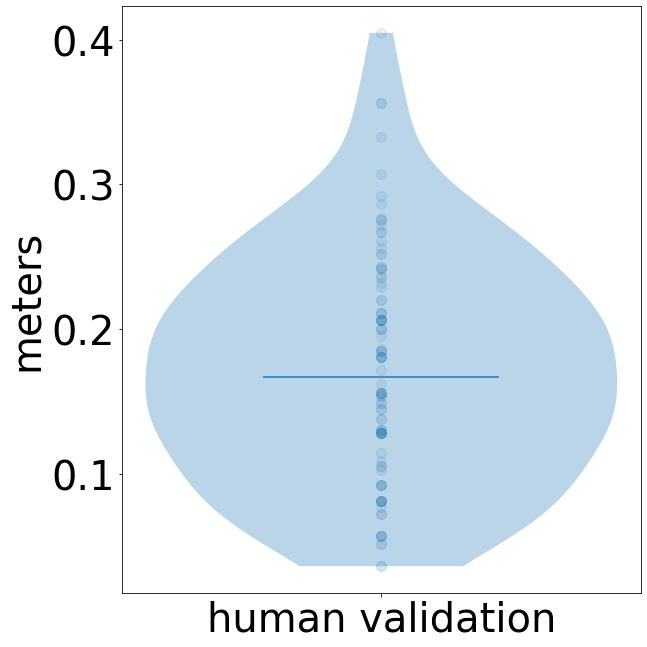

In [5]:
SMALL_SIZE = 40
MEDIUM_SIZE = 40
BIGGER_SIZE = 50

save_fig = False

pixel_to_meters = 0.0256 # from the map with GCP points

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)

# Designed so can plot error from multiple observation together
observation_errors = [np.array(validation_errors['errors']) * pixel_to_meters] 
observation_names = [observation_name]
num_observations = len(observation_errors)

_ = ax.violinplot(observation_errors, 
                  positions=np.arange(num_observations),
                  showmedians=True, showextrema=False)
for obs_num, errors in enumerate(observation_errors):
    ax.scatter(np.ones(len(errors))*obs_num, errors, 
               alpha=.1, marker='o', s=100
              )
_ = ax.set_xticks(np.arange(num_observations))
_ = ax.set_xticklabels(observation_names, rotation='horizontal')
_ = ax.set_xticklabels(["human validation"], rotation='horizontal')
ax.set_ylabel('meters')

# ax.grid(which='minor', alpha=0.0)
# ax.grid(which='major', alpha=1.0)

if save_fig:
    file = os.path.join(local_paths['figure_folder'], 
                    f"{observation_name}_human_validation.png")
    fig.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight')

In [6]:
num_examples = len(errors)
sorted_errors = sorted(errors)
lowwer_quartile = sorted_errors[int(num_examples*.25)]
upper_quartile = sorted_errors[int(num_examples*.75)]
median = np.median(errors)

print(lowwer_quartile, upper_quartile, median)

0.11448668044798925 0.2289733608959785 0.16681931843630246


-0.054090000000000006